<a href="https://colab.research.google.com/github/gecko17k/Learning_Deep_Learning/blob/main/colabs/Training_an_Image_Classification_Model_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Training an Image Classification Model in PyTorch***



#### The primary objective for Hub is to enable users to manage their data more easily so they can train better ML models. This tutorial shows you how to train a simple image classification model while streaming data from a Hub dataset stored in the cloud.

## Install Hub

In [1]:
from IPython.display import clear_output
!pip3 install hub
clear_output()

## Data Preprocessing


The first step is to select a dataset for training. This tutorial uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset that has already been converted into hub format. It is a simple image classification dataset that categorizes images by clothing type (trouser, shirt, etc.)

In [4]:
#Original hub load cell
"""
import hub
from PIL import Image
import numpy as np
import os, time
import torch
from torchvision import datasets, transforms, models

ds_train = hub.load('hub://activeloop/fashion-mnist-train')
ds_test = hub.load('hub://activeloop/fashion-mnist-test')
"""

"\nimport hub\nfrom PIL import Image\nimport numpy as np\nimport os, time\nimport torch\nfrom torchvision import datasets, transforms, models\n\nds_train = hub.load('hub://activeloop/fashion-mnist-train')\nds_test = hub.load('hub://activeloop/fashion-mnist-test')\n"

In [18]:
from PIL import Image
import numpy as np
import time
import torch
from torchvision import datasets, transforms, models

In [22]:
# written by Gemini when I pointed out that I didn't have access to the data.

# Download Fashion MNIST dataset
ds_train = datasets.FashionMNIST(root='./data', train=True, download=True)
ds_test = datasets.FashionMNIST(root='./data', train=False, download=True)

print("Fashion MNIST dataset downloaded successfully!")

Fashion MNIST dataset downloaded successfully!


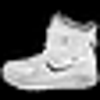

In [23]:
ds_train[0][0].resize((100,100))

In [25]:
print(ds_train.classes[ds_train[0][1]])

Ankle boot


The next step is to define a transformation function that will process the data and convert it into a format that can be passed into a deep learning model. In this particular example, `torchvision.transforms` is used as a part of the transformation pipeline that performs operations such as normalization and image augmentation (rotation).

In [42]:
tform = transforms.Compose([
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.5], [0.5]),
])

You can now create a pytorch dataloader that connects the Hub dataset to the PyTorch model using the provided method `ds.pytorch()`. This method automatically applies the transformation function, takes care of random shuffling (if desired), and converts hub data to PyTorch tensors. The `num_workers` parameter can be used to parallelize data preprocessing, which is critical for ensuring that preprocessing does not bottleneck the overall training workflow.

The `transform` input is a dictionary where the `key` is the tensor name and the `value` is the transformation function that should be applied to that tensor. If a specific tensor's data does not need to be returned, it should be omitted from the keys. If a tensor's data does not need to be modified during preprocessing, the transformation function is set as `None`.

In [43]:
#original
"""
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)
"""


'\nfrom torch.utils.data import DataLoader\n\nbatch_size = 32\n\ntrain_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)\ntest_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)\n'

In [49]:
from torch.utils.data import DataLoader

batch_size = 32

# Apply the transformation when creating the DataLoaders
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=lambda x: (torch.stack([tform(item[0]) for item in x]), torch.tensor([item[1] for item in x])))
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: (torch.stack([tform(item[0]) for item in x]), torch.tensor([item[1] for item in x])))

In [50]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Model Definition

This tutorial uses a pre-trained [ResNet18](https://pytorch.org/hub/pytorch_vision_resnet/) neural network from the torchvision.models module, converted to a single-channel network for grayscale images.

In [51]:
# Simple model can be trained on a CPU
net = models.resnet18(weights='IMAGENET1K_V1') # Use weights argument instead of pretrained
# Convert model to grayscale
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Update the fully connected layer based on the number of classes in the dataset
net.fc = torch.nn.Linear(net.fc.in_features, len(ds_train.classes))

net.to(device)

# Specity the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.1)

## Training the Model

Helper functions for training and testing the model are defined. Note that the dictionary that is returned by the transform function in the PyTorch dataloader is access here and is passed into the model.

In [ ]:
#original
"""
#def train_model(loader, test_loader, model, epochs = 1):
    for epoch in range(epochs):  # loop over the dataset multiple times

        # Zero the performance stats for each epoch
        running_loss = 0.0
        start_time = time.time()
        total = 0
        correct = 0

        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

            # Print performance statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 10 batches
                batch_time = time.time()
                speed = (i+1)/(batch_time-start_time)
                print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                      (epoch + 1, i, running_loss, speed, accuracy))

                running_loss = 0.0

        print('Testing Model Performance')
        test_model(test_loader, model)

    print('Finished Training')


def test_model(loader, model):
    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
        """

In [54]:
def train_model(loader, test_loader, model, epochs = 2):
    for epoch in range(epochs):  # loop over the dataset multiple times

        # Zero the performance stats for each epoch
        running_loss = 0.0
        start_time = time.time()
        total = 0
        correct = 0

        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

            # Print performance statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 10 batches
                batch_time = time.time()
                speed = (i+1)/(batch_time-start_time)
                print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                      (epoch + 1, i, running_loss, speed, accuracy))

                running_loss = 0.0

        print('Testing Model Performance')
        test_model(test_loader, model)

    print('Finished Training')


def test_model(loader, model):
    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

The model and data are ready for training. Let's gooooooooooo 🚀!

In [55]:
train_model(train_loader, test_loader, net, epochs = 1)

[1,     0] loss: 2.638, speed: 1.15, accuracy: 3.12 %
[1,    10] loss: 24.829, speed: 1.73, accuracy: 14.49 %
[1,    20] loss: 21.740, speed: 1.92, accuracy: 16.82 %
[1,    30] loss: 20.378, speed: 1.92, accuracy: 20.06 %
[1,    40] loss: 18.951, speed: 1.98, accuracy: 24.01 %
[1,    50] loss: 18.494, speed: 2.03, accuracy: 26.47 %
[1,    60] loss: 18.088, speed: 2.00, accuracy: 28.23 %
[1,    70] loss: 17.473, speed: 2.04, accuracy: 29.18 %
[1,    80] loss: 15.654, speed: 2.06, accuracy: 31.44 %
[1,    90] loss: 15.580, speed: 2.04, accuracy: 32.93 %
[1,   100] loss: 14.906, speed: 2.06, accuracy: 34.28 %
[1,   110] loss: 13.194, speed: 2.05, accuracy: 36.32 %
[1,   120] loss: 13.311, speed: 2.06, accuracy: 37.71 %
[1,   130] loss: 13.700, speed: 2.07, accuracy: 38.86 %
[1,   140] loss: 12.192, speed: 2.05, accuracy: 40.25 %
[1,   150] loss: 12.412, speed: 2.06, accuracy: 41.35 %
[1,   160] loss: 12.753, speed: 2.07, accuracy: 42.24 %
[1,   170] loss: 11.683, speed: 2.06, accuracy: 43

Congrats! You successfully trained an image classification model while streaming data directly from the cloud! 🎉

# Task
Add a new cell at the end of the notebook to display several images from the test set along with their true and predicted labels, including examples where the model's prediction was correct and incorrect.

## Get predictions

### Subtask:
Obtain a batch of images and labels from the test DataLoader and get the model's predictions for these images.


**Reasoning**:
Iterate through the test_loader to get a batch of images and labels, move them to the correct device, get the model's predictions, and determine the predicted class labels.



In [56]:
# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Move images and labels to the specified device
images = images.to(device)
labels = labels.to(device)

# Get the model's predictions
outputs = net(images)

# Get the predicted class labels
_, predicted = torch.max(outputs.data, 1)

## Select examples

### Subtask:
Identify examples where the model predicted correctly and incorrectly.


**Reasoning**:
Identify correct and incorrect predictions and select a small number of indices from each category.



In [57]:
# Create boolean masks for correct and incorrect predictions
correct_mask = (predicted == labels)
incorrect_mask = ~correct_mask

# Get the indices of correct and incorrect predictions
correct_indices = torch.where(correct_mask)[0]
incorrect_indices = torch.where(incorrect_mask)[0]

# Randomly select a small number of indices from each category (e.g., 4)
num_examples_to_show = 4
selected_correct_indices = correct_indices[torch.randperm(len(correct_indices))[:num_examples_to_show]]
selected_incorrect_indices = incorrect_indices[torch.randperm(len(incorrect_indices))[:num_examples_to_show]]

# Convert selected indices to lists
selected_correct_indices = selected_correct_indices.tolist()
selected_incorrect_indices = selected_incorrect_indices.tolist()

print("Selected correct indices:", selected_correct_indices)
print("Selected incorrect indices:", selected_incorrect_indices)

Selected correct indices: [20, 9, 7, 0]
Selected incorrect indices: [17, 29, 26, 21]


## Visualize results

### Subtask:
Display the selected images along with their true and predicted labels.


**Reasoning**:
Display the selected correct and incorrect predictions with their true and predicted labels.



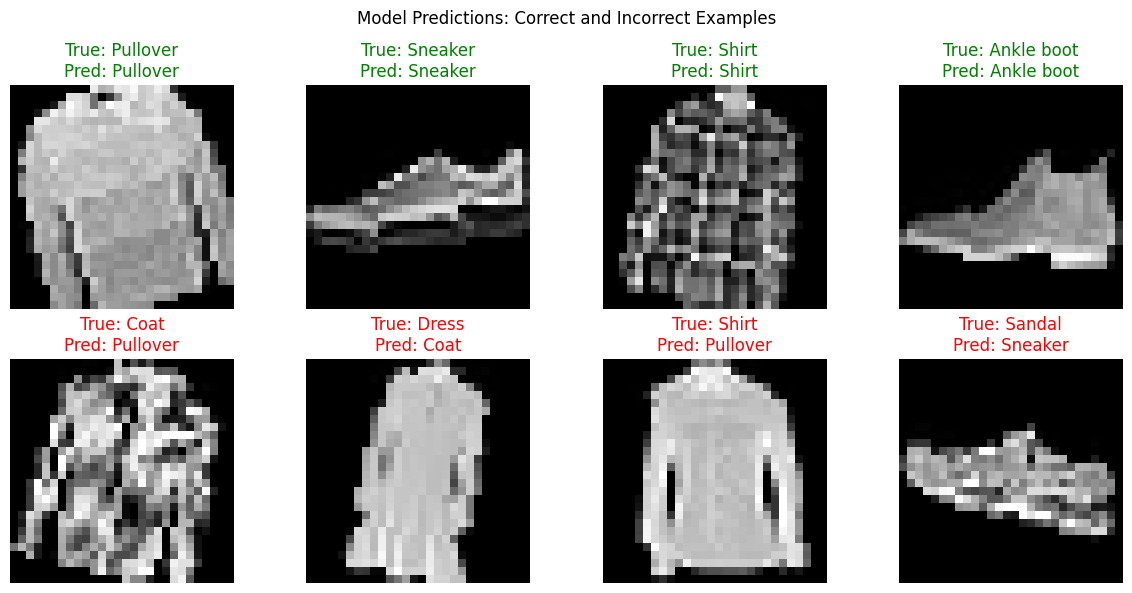

In [58]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axes = plt.subplots(2, num_examples_to_show, figsize=(12, 6))
fig.suptitle("Model Predictions: Correct and Incorrect Examples")

# Display correct predictions
for i, idx in enumerate(selected_correct_indices):
    img = images[idx].detach().cpu().numpy().transpose(1, 2, 0)
    true_label = ds_train.classes[labels[idx].item()]
    predicted_label = ds_train.classes[predicted[idx].item()]

    ax = axes[0, i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color='green')
    ax.axis('off')

# Display incorrect predictions
for i, idx in enumerate(selected_incorrect_indices):
    img = images[idx].detach().cpu().numpy().transpose(1, 2, 0)
    true_label = ds_train.classes[labels[idx].item()]
    predicted_label = ds_train.classes[predicted[idx].item()]

    ax = axes[1, i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color='red')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   A batch of images and labels was successfully obtained from the test DataLoader.
*   The model generated predictions for these images.
*   Boolean masks were created to identify correct and incorrect predictions by comparing predicted labels with true labels.
*   Indices for both correct and incorrect predictions were extracted.
*   A random selection of 4 indices from the correct predictions and 4 indices from the incorrect predictions was made.
*   The selected images corresponding to these indices were displayed using matplotlib.
*   Each displayed image included a title showing the true label and the predicted label, with correct predictions labeled in green and incorrect predictions in red.

### Insights or Next Steps

*   Analyzing the specific incorrect predictions (e.g., image characteristics, true vs. predicted classes) could provide insights into where the model struggles.
*   Expanding the visualization to include more examples or different types of errors could offer a broader understanding of model performance.
